<a href="https://colab.research.google.com/github/armaan10/transcoderplus/blob/v1/model/train_xlm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip utils.zip
!unzip bpe_files.zip

Archive:  utils.zip
   creating: utils/
 extracting: utils/__init__.py       
  inflating: utils/stat_collector.py  
  inflating: utils/parser.py         
  inflating: utils/link.py           
   creating: utils/__pycache__/
  inflating: utils/__pycache__/link.cpython-38.pyc  
  inflating: utils/__pycache__/parser.cpython-38.pyc  
  inflating: utils/code_tokenizer.py  
Archive:  bpe_files.zip
   creating: bpe_files/
  inflating: bpe_files/tokeinzed_cpp.txt  
  inflating: bpe_files/py_train      
  inflating: bpe_files/cpp_train_vocab  
  inflating: bpe_files/codes         
  inflating: bpe_files/py_train_bpe  
  inflating: bpe_files/py_cpp_concat.txt  
  inflating: bpe_files/cpp_train_bpe  
  inflating: bpe_files/tokeinzed_py.txt  
  inflating: bpe_files/fn_cpp_tokens.txt  
  inflating: bpe_files/cpp_train     
  inflating: bpe_files/py_train_vocab  
  inflating: bpe_files/fn_cpp.txt    


In [2]:
import sys
sys.path.insert(1, './utils')
import torch
import torch.nn as nn
import torch.nn.functional as F 
import link
import parser
import random
import time
import math
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [3]:
class EncoderNet(nn.Module):
    def __init__ (self,vocab_size,model_dim,att_h,output_dim,num_layers,pad_idx):
        super(EncoderNet,self).__init__()
        self.encoder_layer=nn.TransformerEncoderLayer(model_dim,att_h,output_dim)   
        self.encoder=nn.TransformerEncoder(self.encoder_layer,num_layers)
        self.pos_enc=PositionalEncoding(model_dim)
        self.emd_py=nn.Embedding(vocab_size[0],model_dim,padding_idx=pad_idx[0])
        self.emd_cpp=nn.Embedding(vocab_size[1],model_dim,padding_idx=pad_idx[1])
        self.linear_py=nn.Linear(output_dim,vocab_size[0])
        self.linear_cpp=nn.Linear(output_dim,vocab_size[1])
    #pad_idx 1 -> pad it there mask_idx 1-> masked idx    
    def forward(self,token_idx,mask_matrix,pad_idx,lang):
        
        if lang=="py":
            inp_vec=self.emd_py(token_idx)
        else :
            inp_vec=self.emd_cpp(token_idx)
        if self.training:
          try:
            assert inp_vec.size()==mask_matrix.size()
          except AssertionError as error:
            error.args+=(inp_vec.size(),mask_matrix.size())
            raise
          #create random vector for mask token
        
          inp_vec=(inp_vec*mask_matrix)
        inp_vec=self.pos_enc(inp_vec)
        output=self.encoder(inp_vec)
        if not self.training:
          return output 
        if lang=="py":
            output=self.linear_py(output)
        else:
            output=self.linear_cpp(output)
        #output=F.softmax(output)
        return output

        



class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)



In [4]:

def make_batches(tokens,no_seqs=32,inp_l=16,pad=True):
    no_iters=int(len(tokens)/(no_seqs*inp_l))
    batches=[]
    total_batch_l=(no_seqs*inp_l)
    
    for i in range(no_iters):
        batch=tokens[i*total_batch_l:(i+1)*(total_batch_l)]
        seqs=[]
        for j in range(no_seqs):
            seqs.append(batch[j*inp_l:inp_l*(j+1)])

        batches.append(seqs)
    rem_batch=tokens[total_batch_l*no_iters:]
    no_iters=int(len(rem_batch)/inp_l)
    
    seqs=[]
    if len(rem_batch)>0:
      for i in range(no_iters):
          seqs.append(rem_batch[i*inp_l:(i+1)*inp_l])
      #pad rem_batch
      if pad:
        padded_seq= rem_batch[no_iters*inp_l:]+["[PAD]"]*abs(len(rem_batch[no_iters*inp_l:]) -inp_l)   
        seqs.append(padded_seq)
      else:
        seqs.append(rem_batch[no_iters*inp_l:])
      
      batches.append(seqs)
    return batches

def mask_tokens(tokens,masking_per=15):
    no_mask_tokens=int(len(tokens)*masking_per/100)
    mask_idx=random.sample(range(0,len(tokens)),no_mask_tokens)
    masked_token_l=[]
    for i in mask_idx:
        masked_token_l.append(tokens[i])
        tokens[i]="[MASK]"
   
    return tokens,masked_token_l    
def make_targets(token_batch,dicto,vocab_vecs):
    batch_v=[]
    for batch in token_batch:
        seq_v=[]
        for seq in batch:
            
            
            seq_v.append(link.lookup(seq,dicto,vocab_vecs))

            #print(vecs.size())
        #print(torch.stack(seq_v))
        batch_v.append(torch.stack(seq_v))
    return batch_v
def get_tokens_idx(token_batch,dicto):
    batch_v=[]
    for batch in token_batch:
        seq_v=[]
        for seq in batch:
            
             l=torch.LongTensor([dicto[x] for x in seq ])
             seq_v.append(l)
        batch_v.append(torch.stack(seq_v))
    return batch_v
#in the form (batch,seqs,tokens)
def get_mask_pad_matrix(embd_dim,token_batch,no_seqs,seq_l):
    batch_mask=[]
    batch_pad=[]
    for batch in token_batch:
        mask_seq=[]
        zeros=torch.zeros(no_seqs,seq_l)
        for seq in batch:
            ones_matrix=torch.ones(len(seq),embd_dim)
            if "[MASK]" in seq:
                random_mask=torch.rand(1,embd_dim)
                ones_matrix[seq.index("[MASK]")]=random_mask
            mask_seq.append(ones_matrix)
        batch_mask.append(torch.stack(mask_seq))
        batch_pad.append(zeros)
    '''if "[PAD]" in token_batch[-1][-1]:
        seq=token_batch[-1][-1]
        pad_l=len(seq)-seq.index("[PAD]")
        pad_idx=torch.ones(1,pad_l)
        batch_pad[-1][-1,seq.index("[PAD]"):]=pad_idx'''
    return batch_mask,batch_pad


In [26]:
vocab_py=parser.read_file("./bpe_files/py_train_vocab")
tokens_py=parser.read_file("./bpe_files/py_train_bpe")
vocab_cpp=parser.read_file("./bpe_files/cpp_train_vocab")
tokens_cpp=parser.read_file("./bpe_files/cpp_train_bpe")

tokens_list_py=[]
tokens_list_cpp=[]
#imp part add later 
for i in tokens_py:
        tokens_list_py+=i.split()
for i in tokens_cpp:
        tokens_list_cpp+=i.split()
dict_py,size_py=link.create_dict(vocab_py)
dict_cpp,size_cpp=link.create_dict(vocab_cpp)
special_tks=["[MASK]","[PAD]"]
dict_py[special_tks[0]]=size_py
dict_py[special_tks[1]]=size_py+1
size_py+=2
dict_cpp[special_tks[0]]=size_cpp
dict_cpp[special_tks[1]]=size_cpp+1
size_cpp+=2
pad_idx=[dict_py[special_tks[1]],dict_cpp[special_tks[1]]]
#print(tokens_list_py)

#reduce cpp for now
tokens_list_cpp=tokens_list_cpp[:20000]

In [27]:
#encoder params def
vocab_size=[size_py,size_cpp]
model_dim=1024
att_h=8
output_dim=1024
num_layers=6
lr=0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=EncoderNet(vocab_size, model_dim, att_h, output_dim,num_layers,pad_idx).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=lr,betas=(0.9,0.98))


In [28]:
#training params
no_seqs=32
seq_l=16
one_hot_vecs_py=torch.eye(size_py)
one_hot_vecs_cpp=torch.eye(size_cpp)



In [ ]:

def train(epochs=100):
    model.train()
    
    #unmasked_train_set_py=make_batches(tokens_list_py)
    #unmasked_train_set_cpp=make_batches(tokens_list_cpp)
    #targets_py=make_targets(unmasked_train_set_py,dict_py,one_hot_vecs_py)
    #print(len(token_list_cpp))
    #targets_cpp=make_targets(unmasked_train_set_cpp,dict_cpp,one_hot_vecs_cpp)
    epl=[]
    l=[]
    loss_total=0
    #run funcs each batch at a time 
    start_time=time.time()
    for ep in range(1,epochs+1):
        no_batches_py=int(len(tokens_list_py)/(no_seqs*seq_l))
        no_batches_cpp=int(len(tokens_list_cpp)/(no_seqs*seq_l))
        
        #mask tokens
        masked_tokens_py,_=mask_tokens(tokens_list_py)
        masked_tokens_cpp,_=mask_tokens(tokens_list_cpp)
        iter_r=0
        py_iter=0
        cpp_iter=0
        for batch_l in range(2*(max(no_batches_cpp,no_batches_py)+1)):
          
          if batch_l%2==0:
            lang="py"
            if py_iter == no_batches_py:
              mask_tokens_l = masked_tokens_py[py_iter*(no_seqs*seq_l):]        
              tokens_list=tokens_list_py[py_iter*(no_seqs*seq_l):]
            
              
            else:
              mask_tokens_l = masked_tokens_py[py_iter*(no_seqs*seq_l):(py_iter+1)*no_seqs*seq_l]        
              tokens_list=tokens_list_py[py_iter*(no_seqs*seq_l):(py_iter+1)*no_seqs*seq_l]
            dicto=dict_py
            one_hot_vecs=one_hot_vecs_py
            py_iter=(py_iter+1)%(no_batches_py+1)
          else :
            lang="cpp"
            if cpp_iter== no_batches_cpp:
              mask_tokens_l = masked_tokens_cpp[cpp_iter*(no_seqs*seq_l):]        
              tokens_list=tokens_list_cpp[cpp_iter*(no_seqs*seq_l):]  
            else:
              mask_tokens_l = masked_tokens_cpp[cpp_iter*(no_seqs*seq_l):(cpp_iter+1)*no_seqs*seq_l]        
              tokens_list=tokens_list_cpp[cpp_iter*(no_seqs*seq_l):(cpp_iter+1)*no_seqs*seq_l]

            dicto=dict_cpp
            one_hot_vecs=one_hot_vecs_cpp
            cpp_iter=(cpp_iter+1)%(no_batches_cpp+1)
          #make training stuff
          masked_batch=make_batches(mask_tokens_l)
          mask_mat,pad_mat=get_mask_pad_matrix(model_dim,masked_batch,no_seqs,seq_l)
          
         
          masked_idx=get_tokens_idx(masked_batch,dicto)
          
          #make targets
          targets=make_batches(tokens_list)
          targets=make_targets(targets,dicto,one_hot_vecs)
          optimizer.zero_grad()
      
          #lang.to(device)
          #print(tokens_idx.size(),pad.size())"
          #print("LANGUAGE",lang)
          output = model(masked_idx[0].to(device),mask_mat[0].to(device),0,lang)
          #print(output.view(no_seqs*seq_l,vocab_size[0]).size(),output.view(no_seqs*seq_l,vocab_size[0]).size())
          output=output.view(-1,vocab_size[0 if lang=="py" else 1])
          number_seqs=targets[0].size()[0]
          targets=targets[0].view(number_seqs*seq_l,vocab_size[0 if lang=="py" else 1]).to(device).long()
          targets=torch.argmax(targets,dim=1)
          #output=torch.argmax(output,dim=1)
          loss=criterion(output,targets)
          #print(loss)
          loss_total+=loss.item()
          loss.backward()
          optimizer.step()
          
               

        """ 
        #make into batches
        masked_batch_py = make_batches(masked_tokens_py)
        masked_batch_cpp=make_batches(masked_tokens_cpp)
        #get padding and masking matrix
        mask_py,pad_py=get_mask_pad_matrix(model_dim, masked_batch_py, no_seqs, seq_l)
        mask_cpp,pad_cpp=get_mask_pad_matrix(model_dim, masked_batch_cpp, no_seqs, seq_l)
        #get token indexes
        masked_idx_py=get_tokens_idx(masked_batch_py, dict_py)
        masked_idx_cpp=get_tokens_idx(masked_batch_cpp, dict_cpp)        
        #alternate batches 
        loss_total=0    
       
        for iter_n in range (len(masked_batch_py)+len(masked_batch_cpp)):
            py_iter=0
            cpp_iter=0
            if iter_n%2==0 or cpp_iter>=len(masked_batch_cpp) and py_iter<len(masked_batch):
              tokens_idx=masked_idx_py[py_iter]
              mask=mask_py[py_iter]
              pad=pad_py[py_iter]
              
              targets=targets_py[py_iter]
              py_iter+=1
              lang="py"
         
            else:
                tokens_idx=masked_idx_cpp[cpp_iter]
                mask=mask_cpp[cpp_iter]
                pad=pad_cpp[cpp_iter]
                targets=targets_cpp[cpp_iter]
                cpp_iter+=1
                
                lang="cpp"
          
            """

        log_int=10
        if ep%log_int ==0:
              end_time=time.time()
              t=end_time-start_time
              start_time=time.time()
              print("time:",t,"epoch:",ep,"loss:",loss_total/log_int)
              epl.append(ep)
              l.append(loss_total/log_int)
              loss_total=0
              
    plt.plot(epl,l)
train()

time: 48.94403028488159 epoch: 10 loss: 224.11830483675004
time: 48.540794134140015 epoch: 20 loss: 57.60091610699892


tensor(310, device='cuda:0')
tensor(310, device='cuda:0')


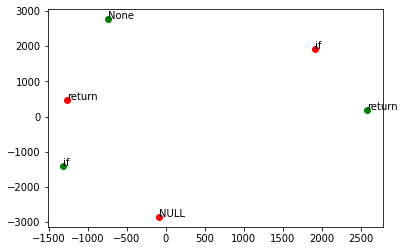

In [24]:
model.eval()
#index 0-py 1-cpp
word_l=[['return','if','None'],['return','if','NULL']]
def visualise_pretrain(word_list):

  
  color=['green','red']
  langs=['py','cpp']
  dict_l=[dict_py,dict_cpp]
  fig,ax=plt.subplots()
  for i,lang in enumerate(langs):
    batches=make_batches(word_list[i],pad=False)
    tokens_idx=get_tokens_idx(batches,dict_l[i])
    
    output=model(tokens_idx[0].to(device),0,0,lang)
    print((output[0,1]==output[0,2]).sum())
    
    output=output.squeeze(0)
   
    output=output.cpu()
    output=output.detach().numpy()
    
    points=TSNE(n_components=2).fit_transform(output)
    ax.scatter(points[:,0],points[:,1],c=color[i])
    for j,txt in enumerate(word_list[i]):
      ax.annotate(txt,(points[j,0],points[j,1]))


visualise_pretrain(word_l) 



In [ ]:
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2).fit_transform(X) 
print(X_embedded,X_embedded[:,1])

In [ ]:
l=[1,2,3]
print(len(l[4:]))